In [1]:
drop_val = 0.4

# LSTM binary

In [2]:
# Importing required libraries
import nltk
nltk.download('stopwords')
nltk.download('wordnet')
import pandas as pd
from nltk.corpus import stopwords
from textblob import Word
from sklearn.preprocessing import LabelEncoder
from collections import Counter
import wordcloud
from sklearn.metrics import classification_report,confusion_matrix,accuracy_score
from keras.models import Sequential
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.layers import Dense, Embedding, LSTM, SpatialDropout1D, GRU, Bidirectional, RNN
from sklearn.model_selection import train_test_split 
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.


In [6]:
#Loading the dataset
data = pd.read_csv('Sarcasm Dataset.csv')

df = data.copy()
df.columns      

Index(['Unnamed: 0', 'tweet', 'sarcastic', 'sarcasm', 'irony', 'satire',
       'understatement', 'overstatement', 'rhetorical_question'],
      dtype='object')

In [7]:
tokenizer = Tokenizer(oov_token="<OOV>")

In [8]:
import re
def cleaning(df):
    # coversion to lower Case
    df['tweet'] = df['tweet'].astype(str).apply(lambda x:' '.join(a.lower() for a in x.split()))

    # Replacing the special characters
    df['tweet'] = df['tweet'].str.replace('\W+', ' ')
#     df['tweet'] = df['tweet'].astype(str).apply(lambda s:''.join([i for i in s if i.isalnum()]))

    # Replacing the digits/numbers

    df['tweet'] = df['tweet'].astype(str).apply(lambda s:''.join([i for i in s if not i.isdigit()]))

    # Removing stop words

#     df['tweet'] = df['tweet'].astype(str).apply(lambda x: ' '.join(a for a in x.split() if a not in stop_words))

    # Lemmatization

    df['tweet'] = df['tweet'].astype(str).apply(lambda x:' '.join([Word(a).lemmatize() for a in x.split()]))

    return df

# stop_words = stopwords.words('english')

df = cleaning(df)
# df.head(20)

In [9]:
import string
sentences = [sublist.split() for sublist in df['tweet'].astype(str).values]
words = set([item for sublist in sentences for item in sublist])
vocab_size = len(words)
vocab_size

9447

In [10]:
df['tweet'] = df['tweet'].astype(str)

In [11]:
# split = round(len(df)*0.75)
# train_reviews = df['tweet'][:split]
# train_label = df['sarcastic'][:split]
# test_reviews = df['tweet'][split:]
# test_label = df['sarcastic'][split:]


In [12]:
# training_sentences = []
# training_labels = []
# testing_sentences = []
# testing_labels = []
# for row in train_reviews:
#     training_sentences.append(str(row))
# for row in train_label:
#     training_labels.append(row)
# for row in test_reviews:
#     testing_sentences.append(str(row))
# for row in test_label:
#     testing_labels.append(row)


In [13]:
import numpy as np
lengths = df["tweet"].str.len()
argmax = np.where(lengths == lengths.max())[0]
# max_len = len(data_v1.iloc[argmax]['tweet'])
max_length = lengths[argmax].astype(int)
print(max_length)
print(np.average(lengths))

2808    294
Name: tweet, dtype: int64
98.53979238754326


In [14]:
# data for binary 
X_train, X_test, y_train, y_test = train_test_split(df['tweet'].values,df['sarcastic'], test_size = 0.25, random_state = 42)
vocab_size = 9440
embedding_dim = 16
max_length = 120
trunc_type = 'post'
oov_tok = '<OOV>'
padding_type = 'post'
tokenizer = Tokenizer(num_words=vocab_size, oov_token=oov_tok)
tokenizer.fit_on_texts(X_train)
word_index = tokenizer.word_index
sequences = tokenizer.texts_to_sequences(X_train)
padded = pad_sequences(sequences, maxlen=max_length, truncating=trunc_type)
testing_sentences = tokenizer.texts_to_sequences(X_test)
testing_padded = pad_sequences(testing_sentences, maxlen=max_length)

In [15]:
# data for multiclass
X_train_mn, X_test_mn, y_train_mn, y_test_mn = train_test_split(df.loc[df['sarcastic']==1, 'tweet'].values, df.loc[df['sarcastic']==1, ['sarcasm', 'irony', 'satire', 'understatement', 'overstatement', 'rhetorical_question']], test_size = 0.25, random_state = 42)
training_labels_final_mn = np.array(y_train_mn)
testing_labels_final_mn = np.array(y_test_mn)
# print(testing_labels_final_mn)
print('labels shape',testing_labels_final_mn.shape)
num_epochs = 20
vocab_size = 9440
embedding_dim = 16
max_length = 120
trunc_type = 'post'
oov_tok = '<OOV>'
padding_type = 'post'
tokenizer_mn = Tokenizer(num_words=vocab_size, oov_token=oov_tok)
tokenizer_mn.fit_on_texts(X_train_mn)
word_index_mn = tokenizer_mn.word_index
sequences_mn = tokenizer_mn.texts_to_sequences(X_train_mn)
padded_mn = pad_sequences(sequences_mn, maxlen=max_length, truncating=trunc_type)
testing_sentences_mn = tokenizer_mn.texts_to_sequences(X_test_mn)
testing_padded_mn = pad_sequences(testing_sentences_mn, maxlen=max_length)

labels shape (217, 6)


In [16]:
# import tensorflow as tf
# model = tf.keras.Sequential([
#     tf.keras.layers.Embedding(vocab_size, embedding_dim, input_length=max_length),
#     tf.keras.layers.GlobalAveragePooling1D(),
#     tf.keras.layers.Dense(6, activation='relu'),
#     tf.keras.layers.Dense(1, activation='sigmoid')
# ])
model = Sequential()
model.add(Embedding(vocab_size, embedding_dim, input_length = max_length))
# model.add(SpatialDropout1D(0.4))
model.add(LSTM(128, dropout=drop_val, recurrent_dropout=drop_val, activation='relu', input_shape=(360,1), return_sequences=True))
model.add(LSTM(128, dropout=drop_val, recurrent_dropout=drop_val, activation='relu', ))
model.add(Dense(16,activation='tanh'))
model.add(Dense(1,activation='softmax'))
model.compile(loss = 'binary_crossentropy', optimizer='adam', metrics = ['accuracy'])
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 120, 16)           151040    
                                                                 
 lstm (LSTM)                 (None, 120, 128)          74240     
                                                                 
 lstm_1 (LSTM)               (None, 128)               131584    
                                                                 
 dense (Dense)               (None, 16)                2064      
                                                                 
 dense_1 (Dense)             (None, 1)                 17        
                                                                 
Total params: 358,945
Trainable params: 358,945
Non-trainable params: 0
_________________________________________________________________


In [17]:
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [18]:
training_labels_final = np.array(y_train)
testing_labels_final = np.array(y_test)
num_epochs = 20
history = model.fit(padded, training_labels_final, epochs=num_epochs, validation_data=(testing_padded, testing_labels_final))

Epoch 1/20
82/82 [==============================] - 60s 662ms/step - loss: 0.5646 - accuracy: 0.2384 - val_loss: 0.5964 - val_accuracy: 0.2849
Epoch 2/20
82/82 [==============================] - 54s 657ms/step - loss: 0.5415 - accuracy: 0.2384 - val_loss: 0.5915 - val_accuracy: 0.2849
Epoch 3/20
82/82 [==============================] - 54s 656ms/step - loss: 0.4871 - accuracy: 0.2384 - val_loss: 0.6720 - val_accuracy: 0.2849
Epoch 4/20
82/82 [==============================] - 54s 656ms/step - loss: 0.4173 - accuracy: 0.2384 - val_loss: 0.7630 - val_accuracy: 0.2849
Epoch 5/20
82/82 [==============================] - 54s 653ms/step - loss: 0.2582 - accuracy: 0.2384 - val_loss: 0.9350 - val_accuracy: 0.2849
Epoch 6/20
82/82 [==============================] - 54s 653ms/step - loss: 0.1534 - accuracy: 0.2384 - val_loss: 0.9923 - val_accuracy: 0.2849
Epoch 7/20
82/82 [==============================] - 54s 654ms/step - loss: 0.0940 - accuracy: 0.2384 - val_loss: 1.2774 - val_accuracy: 0.2849

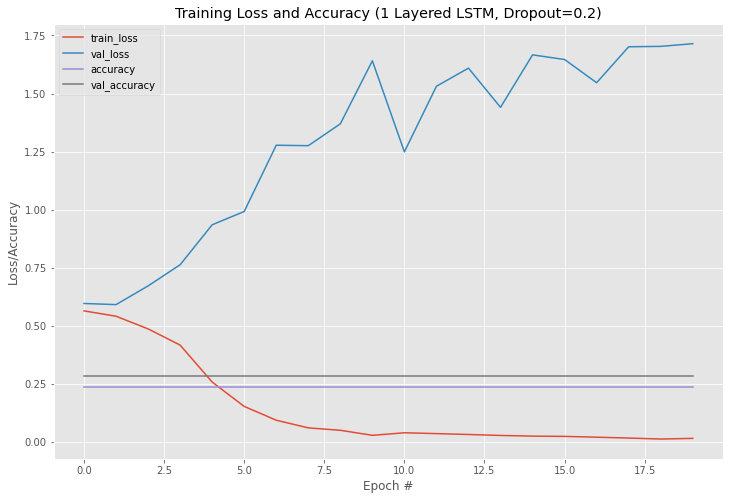

In [19]:
import matplotlib.pyplot as plt
import numpy as np
# plot the training loss and accuracy
plt.rcParams["figure.figsize"] = (12,8)
N = np.arange(0, 20)
plt.style.use("ggplot")
plt.figure()
plt.plot(N, history.history["loss"], label="train_loss")
plt.plot(N, history.history["val_loss"], label="val_loss")
plt.plot(N, history.history['accuracy'], label="accuracy")
plt.plot(N, history.history["val_accuracy"], label="val_accuracy")
plt.title("Training Loss and Accuracy (1 Layered LSTM, Dropout=0.2)")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend()

In [20]:
# confusion matrix in sklearn
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
 
# actual values
actual = testing_labels_final
# predicted values
predicted = model.predict(testing_padded)

# confusion matrix
matrix = confusion_matrix(actual,predicted, labels=[1,0])
print('Confusion matrix : \n',matrix)

# outcome values order in sklearn
tp, fn, fp, tn = confusion_matrix(actual,predicted,labels=[1,0]).reshape(-1)
print('Outcome values : \n', tp, fn, fp, tn)

# classification report for precision, recall f1-score and accuracy
matrix = classification_report(actual,predicted,labels=[1,0])
print('Classification report : \n',matrix)

Confusion matrix : 
 [[247   0]
 [620   0]]
Outcome values : 
 247 0 620 0
Classification report : 
               precision    recall  f1-score   support

           1       0.28      1.00      0.44       247
           0       0.00      0.00      0.00       620

    accuracy                           0.28       867
   macro avg       0.14      0.50      0.22       867
weighted avg       0.08      0.28      0.13       867



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


# LSTM multi class 2 layered

In [21]:
import tensorflow as tf
# model = tf.keras.Sequential([
#     tf.keras.layers.Embedding(vocab_size, embedding_dim, input_length=max_length),
#     tf.keras.layers.GlobalAveragePooling1D(),
#     tf.keras.layers.Dense(6, activation='relu'),
#     tf.keras.layers.Dense(1, activation='sigmoid')
# ])

model2 = Sequential()
model2.add(Embedding(vocab_size, embedding_dim, input_length = max_length))
# model.add(SpatialDropout1D(0.4))
model2.add(LSTM(128, dropout=drop_val, recurrent_dropout=drop_val, activation='LeakyReLU', input_shape=(360,1), return_sequences=True))
model2.add(LSTM(128, dropout=drop_val, recurrent_dropout=drop_val, activation='LeakyReLU', ))
model2.add(Dense(36,activation='tanh'))
model2.add(Dense(6,activation='sigmoid'))
model2.compile(loss = tf.keras.losses.CategoricalCrossentropy(), optimizer='sgd', metrics = ['accuracy'])
model2.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 120, 16)           151040    
                                                                 
 lstm_2 (LSTM)               (None, 120, 128)          74240     
                                                                 
 lstm_3 (LSTM)               (None, 128)               131584    
                                                                 
 dense_2 (Dense)             (None, 36)                4644      
                                                                 
 dense_3 (Dense)             (None, 6)                 222       
                                                                 
Total params: 361,730
Trainable params: 361,730
Non-trainable params: 0
_________________________________________________________________


In [22]:
num_epochs = 20
history2 = model2.fit(padded_mn, training_labels_final_mn, epochs=num_epochs, validation_data=(testing_padded_mn, testing_labels_final_mn))

Epoch 1/20
21/21 [==============================] - 20s 724ms/step - loss: 2.0085 - accuracy: 0.7846 - val_loss: 1.7982 - val_accuracy: 0.8525
Epoch 2/20
21/21 [==============================] - 14s 687ms/step - loss: 1.7244 - accuracy: 0.8123 - val_loss: 1.5427 - val_accuracy: 0.8525
Epoch 3/20
21/21 [==============================] - 14s 681ms/step - loss: 1.5250 - accuracy: 0.8123 - val_loss: 1.3677 - val_accuracy: 0.8525
Epoch 4/20
21/21 [==============================] - 14s 670ms/step - loss: 1.3998 - accuracy: 0.8123 - val_loss: 1.2648 - val_accuracy: 0.8525
Epoch 5/20
21/21 [==============================] - 14s 663ms/step - loss: 1.3353 - accuracy: 0.8123 - val_loss: 1.2169 - val_accuracy: 0.8525
Epoch 6/20
21/21 [==============================] - 14s 661ms/step - loss: 1.3069 - accuracy: 0.8123 - val_loss: 1.1964 - val_accuracy: 0.8525
Epoch 7/20
21/21 [==============================] - 14s 661ms/step - loss: 1.2983 - accuracy: 0.8123 - val_loss: 1.1909 - val_accuracy: 0.8525

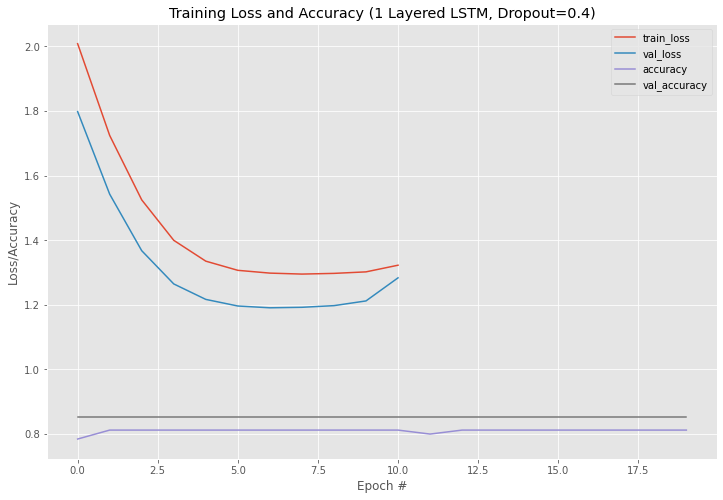

In [23]:
import matplotlib.pyplot as plt
import numpy as np
# plot the training loss and accuracy
plt.rcParams["figure.figsize"] = (12,8)
N = np.arange(0, 20)
plt.style.use("ggplot")
plt.figure()
plt.plot(N, history2.history["loss"], label="train_loss")
plt.plot(N, history2.history["val_loss"], label="val_loss")
plt.plot(N, history2.history['accuracy'], label="accuracy")
plt.plot(N, history2.history["val_accuracy"], label="val_accuracy")
plt.title("Training Loss and Accuracy (1 Layered LSTM, Dropout="+str(drop_val)+')')
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend()

# Vanilla RNN

In [24]:
# model3 = Sequential()
# model3.add(Embedding(vocab_size, embedding_dim, input_length = max_length))
# # model.add(SpatialDropout1D(0.4))
# model3.add(Dense(256,activation='relu'))
# model3.add(Dense(128,activation='tanh'))
# model3.add(Dense(1,activation='sigmoid'))
# model3.compile(loss = 'binary_crossentropy', optimizer='adam', metrics = ['accuracy'])
# model3.summary()
import tensorflow as tf
model3 = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, embedding_dim, input_length=max_length),
    tf.keras.layers.GlobalAveragePooling1D(),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])
model3.compile(loss = 'binary_crossentropy', optimizer='adam', metrics = ['accuracy'])
model3.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_2 (Embedding)     (None, 120, 16)           151040    
                                                                 
 global_average_pooling1d (G  (None, 16)               0         
 lobalAveragePooling1D)                                          
                                                                 
 dense_4 (Dense)             (None, 128)               2176      
                                                                 
 dense_5 (Dense)             (None, 128)               16512     
                                                                 
 dense_6 (Dense)             (None, 1)                 129       
                                                                 
Total params: 169,857
Trainable params: 169,857
Non-trainable params: 0
________________________________________________

In [25]:
training_labels_final = np.array(y_train)
testing_labels_final = np.array(y_test)
num_epochs = 20
history3 = model3.fit(padded, training_labels_final, epochs=num_epochs, validation_data=(testing_padded, testing_labels_final))

Epoch 1/20
82/82 [==============================] - 1s 8ms/step - loss: 0.5774 - accuracy: 0.7616 - val_loss: 0.6174 - val_accuracy: 0.7151
Epoch 2/20
82/82 [==============================] - 0s 6ms/step - loss: 0.5495 - accuracy: 0.7616 - val_loss: 0.6022 - val_accuracy: 0.7151
Epoch 3/20
82/82 [==============================] - 0s 6ms/step - loss: 0.5461 - accuracy: 0.7616 - val_loss: 0.6005 - val_accuracy: 0.7151
Epoch 4/20
82/82 [==============================] - 0s 6ms/step - loss: 0.5395 - accuracy: 0.7616 - val_loss: 0.5943 - val_accuracy: 0.7151
Epoch 5/20
82/82 [==============================] - 0s 6ms/step - loss: 0.5130 - accuracy: 0.7616 - val_loss: 0.5845 - val_accuracy: 0.7163
Epoch 6/20
82/82 [==============================] - 0s 5ms/step - loss: 0.4159 - accuracy: 0.7939 - val_loss: 0.6127 - val_accuracy: 0.7140
Epoch 7/20
82/82 [==============================] - 0s 6ms/step - loss: 0.2930 - accuracy: 0.8804 - val_loss: 0.7158 - val_accuracy: 0.7070
Epoch 8/20
82/82 [==

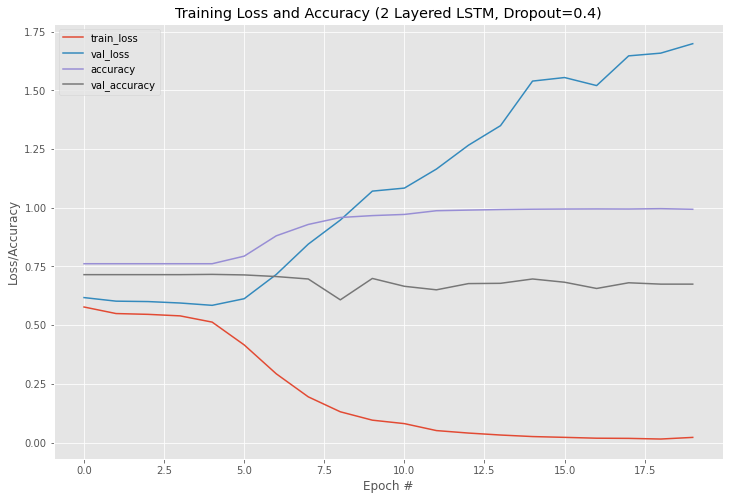

In [26]:
import matplotlib.pyplot as plt
import numpy as np
# plot the training loss and accuracy
plt.rcParams["figure.figsize"] = (12,8)
N = np.arange(0, 20)
plt.style.use("ggplot")
plt.figure()
plt.plot(N, history3.history["loss"], label="train_loss")
plt.plot(N, history3.history["val_loss"], label="val_loss")
plt.plot(N, history3.history['accuracy'], label="accuracy")
plt.plot(N, history3.history["val_accuracy"], label="val_accuracy")
plt.title("Training Loss and Accuracy (2 Layered LSTM, Dropout="+str(drop_val)+')')
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend()

In [27]:
# confusion matrix in sklearn
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
 
# actual values
actual = testing_labels_final
# predicted values
predicted = model3.predict(testing_padded)

# confusion matrix
matrix = confusion_matrix(actual,np.array([int((val-0.5)>0) for val in predicted]), labels=[1,0])
print('Confusion matrix : \n',matrix)

# outcome values order in sklearn
tp, fn, fp, tn = confusion_matrix(actual,np.array([int((val-0.5)>0) for val in predicted]),labels=[1,0]).reshape(-1)
print('Outcome values (tp, fn, fp, tn): \n', tp, fn, fp, tn)

# classification report for precision, recall f1-score and accuracy
matrix = classification_report(actual,np.array([int((val-0.5)>0) for val in predicted]),labels=[1,0])
print('Classification report : \n',matrix)

Confusion matrix : 
 [[ 71 176]
 [106 514]]
Outcome values (tp, fn, fp, tn): 
 71 176 106 514
Classification report : 
               precision    recall  f1-score   support

           1       0.40      0.29      0.33       247
           0       0.74      0.83      0.78       620

    accuracy                           0.67       867
   macro avg       0.57      0.56      0.56       867
weighted avg       0.65      0.67      0.66       867



# Vanilla RNN multiclass

In [28]:
model4 = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, embedding_dim, input_length=max_length),
    tf.keras.layers.GlobalAveragePooling1D(),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(6, activation='sigmoid')
])
model4.compile(loss = 'categorical_crossentropy', optimizer='adam', metrics = ['accuracy'])
model4.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_3 (Embedding)     (None, 120, 16)           151040    
                                                                 
 global_average_pooling1d_1   (None, 16)               0         
 (GlobalAveragePooling1D)                                        
                                                                 
 dense_7 (Dense)             (None, 128)               2176      
                                                                 
 dense_8 (Dense)             (None, 128)               16512     
                                                                 
 dense_9 (Dense)             (None, 6)                 774       
                                                                 
Total params: 170,502
Trainable params: 170,502
Non-trainable params: 0
________________________________________________

In [29]:
X_train_mn, X_test_mn, y_train_mn, y_test_mn = train_test_split(df.loc[df['sarcastic']==1, 'tweet'].values, df.loc[df['sarcastic']==1, ['sarcasm', 'irony', 'satire', 'understatement', 'overstatement', 'rhetorical_question']], test_size = 0.25, random_state = 42)
training_labels_final_mn = np.array(y_train_mn)
testing_labels_final_mn = np.array(y_test_mn)
# print(testing_labels_final_mn)
print('labels shape',testing_labels_final_mn.shape)
num_epochs = 20
vocab_size = 9440
embedding_dim = 16
max_length = 120
trunc_type = 'post'
oov_tok = '<OOV>'
padding_type = 'post'
tokenizer_mn = Tokenizer(num_words=vocab_size, oov_token=oov_tok)
tokenizer_mn.fit_on_texts(X_train_mn)
word_index_mn = tokenizer_mn.word_index
sequences_mn = tokenizer_mn.texts_to_sequences(X_train_mn)
padded_mn = pad_sequences(sequences_mn, maxlen=max_length, truncating=trunc_type)
testing_sentences_mn = tokenizer_mn.texts_to_sequences(X_test_mn)
testing_padded_mn = pad_sequences(testing_sentences_mn, maxlen=max_length)

labels shape (217, 6)


In [30]:
history4 = model4.fit(padded_mn, training_labels_final_mn, epochs=num_epochs, validation_data=(testing_padded_mn, testing_labels_final_mn))

Epoch 1/20
21/21 [==============================] - 1s 15ms/step - loss: 2.0688 - accuracy: 0.7369 - val_loss: 1.8587 - val_accuracy: 0.8525
Epoch 2/20
21/21 [==============================] - 0s 7ms/step - loss: 1.6128 - accuracy: 0.8123 - val_loss: 1.2160 - val_accuracy: 0.8525
Epoch 3/20
21/21 [==============================] - 0s 6ms/step - loss: 1.3371 - accuracy: 0.8123 - val_loss: 1.2503 - val_accuracy: 0.8525
Epoch 4/20
21/21 [==============================] - 0s 6ms/step - loss: 1.3390 - accuracy: 0.8123 - val_loss: 1.2527 - val_accuracy: 0.8525
Epoch 5/20
21/21 [==============================] - 0s 7ms/step - loss: 1.3913 - accuracy: 0.8123 - val_loss: 1.4104 - val_accuracy: 0.8525
Epoch 6/20
21/21 [==============================] - 0s 6ms/step - loss: 1.5518 - accuracy: 0.8123 - val_loss: 1.6207 - val_accuracy: 0.8525
Epoch 7/20
21/21 [==============================] - 0s 8ms/step - loss: 1.9076 - accuracy: 0.8123 - val_loss: 2.2270 - val_accuracy: 0.8525
Epoch 8/20
21/21 [=

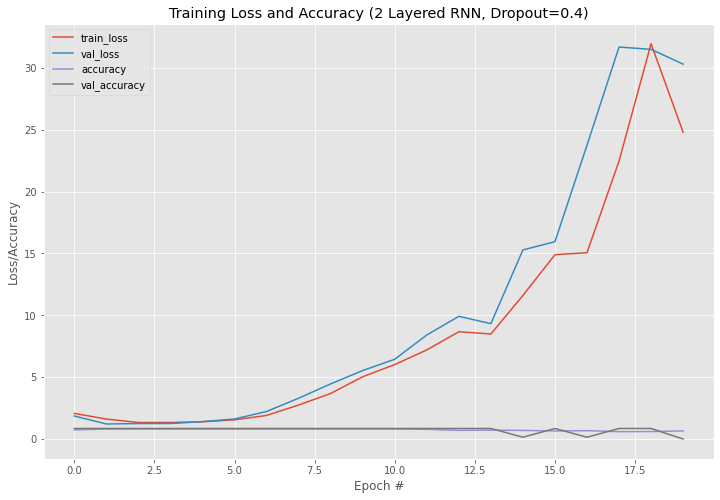

In [31]:
import matplotlib.pyplot as plt
import numpy as np
# plot the training loss and accuracy
plt.rcParams["figure.figsize"] = (12,8)
N = np.arange(0, 20)
plt.style.use("ggplot")
plt.figure()
plt.plot(N, history4.history["loss"], label="train_loss")
plt.plot(N, history4.history["val_loss"], label="val_loss")
plt.plot(N, history4.history['accuracy'], label="accuracy")
plt.plot(N, history4.history["val_accuracy"], label="val_accuracy")
plt.title("Training Loss and Accuracy (2 Layered RNN, Dropout="+str(drop_val)+')')
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend()

# GRU 2 layered binary

In [32]:
model5 = Sequential()
model5.add(Embedding(vocab_size, embedding_dim, input_length = max_length))
# model.add(SpatialDropout1D(0.4))
model5.add(GRU(128, dropout=drop_val, recurrent_dropout=drop_val, activation='LeakyReLU', input_shape=(360,1), return_sequences=True))
model5.add(GRU(128, dropout=drop_val, recurrent_dropout=drop_val, activation='LeakyReLU', ))
model5.add(Dense(36,activation='tanh'))
model5.add(Dense(1,activation='sigmoid'))
model5.compile(loss = 'binary_crossentropy', optimizer='adam', metrics = ['accuracy'])
model5.summary()


Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_4 (Embedding)     (None, 120, 16)           151040    
                                                                 
 gru (GRU)                   (None, 120, 128)          56064     
                                                                 
 gru_1 (GRU)                 (None, 128)               99072     
                                                                 
 dense_10 (Dense)            (None, 36)                4644      
                                                                 
 dense_11 (Dense)            (None, 1)                 37        
                                                                 
Total params: 310,857
Trainable params: 310,857
Non-trainable params: 0
_________________________________________________________________


In [33]:
training_labels_final = np.array(y_train)
testing_labels_final = np.array(y_test)
num_epochs = 20
history5 = model5.fit(padded, training_labels_final, epochs=num_epochs, validation_data=(testing_padded, testing_labels_final))

Epoch 1/20
82/82 [==============================] - 52s 574ms/step - loss: 0.5629 - accuracy: 0.7547 - val_loss: 0.5968 - val_accuracy: 0.7151
Epoch 2/20
82/82 [==============================] - 46s 567ms/step - loss: 0.5389 - accuracy: 0.7616 - val_loss: 0.5947 - val_accuracy: 0.7128
Epoch 3/20
82/82 [==============================] - 46s 564ms/step - loss: 0.4341 - accuracy: 0.8012 - val_loss: 0.7208 - val_accuracy: 0.6655
Epoch 4/20
82/82 [==============================] - 46s 564ms/step - loss: 0.2625 - accuracy: 0.8927 - val_loss: 0.8965 - val_accuracy: 0.5594
Epoch 5/20
82/82 [==============================] - 47s 568ms/step - loss: 0.1671 - accuracy: 0.9393 - val_loss: 0.9307 - val_accuracy: 0.6551
Epoch 6/20
82/82 [==============================] - 46s 567ms/step - loss: 0.0923 - accuracy: 0.9696 - val_loss: 1.2418 - val_accuracy: 0.6632
Epoch 7/20
82/82 [==============================] - 46s 567ms/step - loss: 0.0665 - accuracy: 0.9719 - val_loss: 1.6093 - val_accuracy: 0.6251

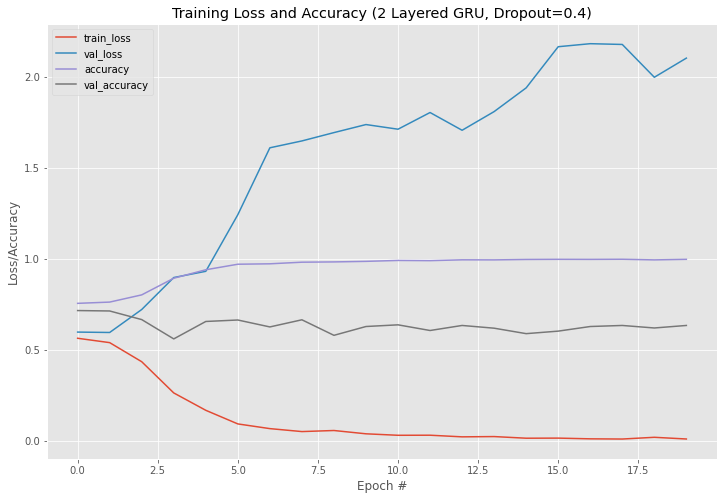

In [34]:
import matplotlib.pyplot as plt
import numpy as np
# plot the training loss and accuracy
plt.rcParams["figure.figsize"] = (12,8)
N = np.arange(0, 20)
plt.style.use("ggplot")
plt.figure()
plt.plot(N, history5.history["loss"], label="train_loss")
plt.plot(N, history5.history["val_loss"], label="val_loss")
plt.plot(N, history5.history['accuracy'], label="accuracy")
plt.plot(N, history5.history["val_accuracy"], label="val_accuracy")
plt.title("Training Loss and Accuracy (2 Layered GRU, Dropout="+str(drop_val)+')')
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend()

In [35]:
# confusion matrix in sklearn
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
 
# actual values
actual = testing_labels_final
# predicted values
predicted = model5.predict(testing_padded)

# confusion matrix
matrix = confusion_matrix(actual,np.array([int((val-0.5)>0) for val in predicted]), labels=[1,0])
print('Confusion matrix : \n',matrix)

# outcome values order in sklearn
tp, fn, fp, tn = confusion_matrix(actual,np.array([int((val-0.5)>0) for val in predicted]),labels=[1,0]).reshape(-1)
print('Outcome values (tp, fn, fp, tn): \n', tp, fn, fp, tn)

# classification report for precision, recall f1-score and accuracy
matrix = classification_report(actual,np.array([int((val-0.5)>0) for val in predicted]),labels=[1,0])
print('Classification report : \n',matrix)

Confusion matrix : 
 [[ 73 174]
 [144 476]]
Outcome values (tp, fn, fp, tn): 
 73 174 144 476
Classification report : 
               precision    recall  f1-score   support

           1       0.34      0.30      0.31       247
           0       0.73      0.77      0.75       620

    accuracy                           0.63       867
   macro avg       0.53      0.53      0.53       867
weighted avg       0.62      0.63      0.63       867



# GRU 2 Layered Multiclass

In [36]:
model6 = Sequential()
model6.add(Embedding(vocab_size, embedding_dim, input_length = max_length))
# model.add(SpatialDropout1D(0.4))
model6.add(GRU(128, dropout=drop_val, recurrent_dropout=drop_val, activation='LeakyReLU', input_shape=(360,1), return_sequences=True))
model6.add(GRU(128, dropout=drop_val, recurrent_dropout=drop_val, activation='LeakyReLU', ))
model6.add(Dense(36,activation='tanh'))
model6.add(Dense(6,activation='sigmoid'))
model6.compile(loss = tf.keras.losses.CategoricalCrossentropy(), optimizer='adam', metrics = ['accuracy'])
model6.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_5 (Embedding)     (None, 120, 16)           151040    
                                                                 
 gru_2 (GRU)                 (None, 120, 128)          56064     
                                                                 
 gru_3 (GRU)                 (None, 128)               99072     
                                                                 
 dense_12 (Dense)            (None, 36)                4644      
                                                                 
 dense_13 (Dense)            (None, 6)                 222       
                                                                 
Total params: 311,042
Trainable params: 311,042
Non-trainable params: 0
_________________________________________________________________


In [37]:
training_labels_final = np.array(y_train)
testing_labels_final = np.array(y_test)
num_epochs = 20
history6 = model6.fit(padded_mn, training_labels_final_mn, epochs=num_epochs, validation_data=(testing_padded_mn, testing_labels_final_mn))

Epoch 1/20
21/21 [==============================] - 18s 607ms/step - loss: 1.7959 - accuracy: 0.7769 - val_loss: 1.4053 - val_accuracy: 0.8525
Epoch 2/20
21/21 [==============================] - 12s 577ms/step - loss: 1.4398 - accuracy: 0.8123 - val_loss: 1.4198 - val_accuracy: 0.8525
Epoch 3/20
21/21 [==============================] - 12s 571ms/step - loss: 1.4689 - accuracy: 0.8123 - val_loss: 1.3254 - val_accuracy: 0.8525
Epoch 4/20
21/21 [==============================] - 12s 578ms/step - loss: 1.3763 - accuracy: 0.8123 - val_loss: 1.3063 - val_accuracy: 0.8525
Epoch 5/20
21/21 [==============================] - 12s 573ms/step - loss: 1.3736 - accuracy: 0.8123 - val_loss: 1.2965 - val_accuracy: 0.8525
Epoch 6/20
21/21 [==============================] - 12s 572ms/step - loss: 1.3584 - accuracy: 0.8123 - val_loss: 1.2858 - val_accuracy: 0.8525
Epoch 7/20
21/21 [==============================] - 12s 586ms/step - loss: 1.3530 - accuracy: 0.8123 - val_loss: 1.2775 - val_accuracy: 0.8525

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
# plot the training loss and accuracy
plt.rcParams["figure.figsize"] = (12,8)
N = np.arange(0, 20)
plt.style.use("ggplot")
plt.figure()
plt.plot(N, history6.history["loss"], label="train_loss")
plt.plot(N, history6.history["val_loss"], label="val_loss")
plt.plot(N, history6.history['accuracy'], label="accuracy")
plt.plot(N, history6.history["val_accuracy"], label="val_accuracy")
plt.title("Training Loss and Accuracy (2 Layered GRU, Dropout="+str(drop_val)+')')
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend()

#BiLSTM

In [ ]:
model7 = Sequential()
model7.add(Embedding(vocab_size, embedding_dim, input_length = max_length))
model7.add(Bidirectional(LSTM(20, return_sequences=True, dropout=drop_val, activation='LeakyReLU')))
model7.add(Bidirectional(LSTM(20, dropout=drop_val, activation='LeakyReLU')))
model7.add(Dense(36,activation='tanh'))
model7.add(Dense(1,activation='sigmoid'))
model7.compile(loss = 'binary_crossentropy', optimizer='adam', metrics = ['accuracy'])
model7.summary()



In [ ]:
training_labels_final = np.array(y_train)
testing_labels_final = np.array(y_test)
num_epochs = 20
history7 = model7.fit(padded, training_labels_final, epochs=num_epochs, validation_data=(testing_padded, testing_labels_final))

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
# plot the training loss and accuracy
plt.rcParams["figure.figsize"] = (12,8)
N = np.arange(0, 20)
plt.style.use("ggplot")
plt.figure()
plt.plot(N, history7.history["loss"], label="train_loss")
plt.plot(N, history7.history["val_loss"], label="val_loss")
plt.plot(N, history7.history['accuracy'], label="accuracy")
plt.plot(N, history7.history["val_accuracy"], label="val_accuracy")
plt.title("Training Loss and Accuracy (2 Layered bidirectional LSTM, Dropout="+str(drop_val)+')')
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend()

In [42]:
# confusion matrix in sklearn
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
 
# actual values
actual = testing_labels_final
# predicted values
predicted = model5.predict(testing_padded)

# confusion matrix
matrix = confusion_matrix(actual,np.array([int((val)>0) for val in predicted]), labels=[1,0])
print('Confusion matrix : \n',matrix)

# outcome values order in sklearn
tp, fn, fp, tn = confusion_matrix(actual,np.array([int((val)>0) for val in predicted]),labels=[1,0]).reshape(-1)
print('Outcome values (tp, fn, fp, tn): \n', tp, fn, fp, tn)

# classification report for precision, recall f1-score and accuracy
matrix = classification_report(actual,np.array([int((val)>0) for val in predicted]),labels=[1,0])
print('Classification report : \n',matrix)

Confusion matrix : 
 [[247   0]
 [620   0]]
Outcome values (tp, fn, fp, tn): 
 247 0 620 0
Classification report : 
               precision    recall  f1-score   support

           1       0.28      1.00      0.44       247
           0       0.00      0.00      0.00       620

    accuracy                           0.28       867
   macro avg       0.14      0.50      0.22       867
weighted avg       0.08      0.28      0.13       867



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


#BiDirectional LSTM multi-class

In [ ]:
model8 = Sequential()
model8.add(Embedding(vocab_size, embedding_dim, input_length = max_length))
model8.add(Bidirectional(LSTM(128, return_sequences=True, dropout=drop_val, activation='tanh')))
model8.add(Bidirectional(LSTM(128, dropout=drop_val, activation='tanh')))
model8.add(Dense(36,activation='tanh'))
model8.add(Dense(6,activation='sigmoid'))
model8.compile(loss = tf.keras.losses.CategoricalCrossentropy(), optimizer='adam', metrics = ['accuracy'])
model8.summary()



In [ ]:
training_labels_final = np.array(y_train)
testing_labels_final = np.array(y_test)
num_epochs = 20
history8 = model8.fit(padded_mn, training_labels_final_mn, epochs=num_epochs, validation_data=(testing_padded_mn, testing_labels_final_mn))

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
# plot the training loss and accuracy
plt.rcParams["figure.figsize"] = (12,8)
N = np.arange(0, 20)
plt.style.use("ggplot")
plt.figure()
plt.plot(N, history7.history["loss"], label="train_loss")
plt.plot(N, history7.history["val_loss"], label="val_loss")
plt.plot(N, history7.history['accuracy'], label="accuracy")
plt.plot(N, history7.history["val_accuracy"], label="val_accuracy")
plt.title("Training Loss and Accuracy (2 Layered bidirectional LSTM, Dropout="+str(drop_val)+')')
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend()